In [1]:
import os
import gc
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter, medfilt

sns.set(font_scale=1.5)
# sns.color_palette("hls", 64)
sns.set_style("white", {'font.family':'serif', 'font.serif':'Times New Roman'})



# Constants

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_1 = 'gait-dbase-1/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

# Filter 

In [3]:
class LowPassFilter(object):
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=6, fs=1500, order=2, axis=-1):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data, axis=axis)
        y = y - np.median(y)
        return y


# Functions

In [4]:
def standardize(x):
    # return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

def get_processed_grf(grf, clip=False):
    singn_corrected = grf # if np.mean(grf) > 20 else (-grf)
    processed_grf = LowPassFilter.apply(singn_corrected, fs=1500, cutoff=15)
    processed_grf = processed_grf - np.median(processed_grf)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 3, axis=0).T

def get_processed_moment(moment):
    processed_moment = LowPassFilter.apply(moment, fs=1500, cutoff=20)
    return resample(processed_moment, N_SAMPLES * 3, axis=0).T

def get_trajectories(content, foot='right'):
    if foot == 'right':
        trajectory_x = content['data']['points'][0, 9:15, :]
        trajectory_y = content['data']['points'][1, 9:15, :]
        trajectory_z = content['data']['points'][2, 9:15, :]

    elif foot == 'left':
        trajectory_x = content['data']['points'][0, 20:26, :]
        trajectory_y = content['data']['points'][1, 20:26, :]
        trajectory_z = content['data']['points'][2, 20:26, :]

    else:
        raise ValueError('Third foot is not allowed')

    trajectory_x = LowPassFilter.apply(trajectory_x, fs=100, cutoff=6, order=4)
    trajectory_y = LowPassFilter.apply(trajectory_y, fs=100, cutoff=6, order=4)
    trajectory_z = LowPassFilter.apply(trajectory_z, fs=100, cutoff=6, order=4)

    trajectory_x = resample(trajectory_x, N_SAMPLES * 3, axis=1).T
    trajectory_y = resample(trajectory_y, N_SAMPLES * 3, axis=1).T
    trajectory_z = resample(trajectory_z, N_SAMPLES * 3, axis=1).T

    return trajectory_x, trajectory_y, trajectory_z

def get_force(content):
    force_x = []
    force_y = []
    force_z = []
    for i in range(2):
        force_x.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][1, :]
            )
        )
        force_y.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][0, :]
            )
        )
        force_z.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][2, :], True
            )
        )

    return force_x, force_y, force_z

def get_moment(content):
    moment_x = []
    moment_y = []
    moment_z = []
    for i in range(2):
        moment_x.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][1, :]
            )
        )
        moment_y.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][0, :]
            )
        )
        moment_z.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][2, :]
            )
        )

    return moment_x, moment_y, moment_z

# Test Bench

In [ ]:
path = '/home/ai/Python/GRF-Synthesis-from-Motion-Trajectories/Dataset/gait-dbase-1/2014001/2014001_C1_04.c3d'
content = c3d(path, extract_forceplat_data=True)

In [ ]:
trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

force_x, force_y, force_z = get_force(content)
moment_x, moment_y, moment_z = get_moment(content)

In [ ]:
plt.plot(trajectory_z_l[:, 0])
plt.plot(trajectory_z_r[:, 0])
plt.show()

In [ ]:
plt.plot(force_y[0])
plt.plot(force_y[1])
plt.show()

In [ ]:
plt.plot(moment_y[0])
plt.plot(moment_y[1])
plt.show()

In [ ]:
mask_force_z_1 = (force_z[0] > FORCE_THRESHOLD)
mask_force_z_2 = (force_z[1] > FORCE_THRESHOLD)

start_1 = np.min(np.argwhere(mask_force_z_1 == True))
end_1 = np.max(np.argwhere(mask_force_z_1 == True))

start_2 = np.min(np.argwhere(mask_force_z_2 == True))
end_2 = np.max(np.argwhere(mask_force_z_2 == True))

force_x_1 = force_x[0][start_1 : end_1]
force_y_1 = force_y[0][start_1 : end_1]
force_z_1 = force_z[0][start_1 : end_1]

force_x_2 = force_x[1][start_2 : end_2]
force_y_2 = force_y[1][start_2 : end_2]
force_z_2 = force_z[1][start_2 : end_2]

temp_l = trajectory_z_l[start_1 : end_1, 0]
temp_r = trajectory_z_r[start_1 : end_1, 0]

force_x_r = 0
force_y_r = 0
force_z_r = 0

force_x_l = 0
force_y_l = 0
force_z_l = 0

if np.sum(temp_l) > np.sum(temp_r):
    force_x_r = force_x_1
    force_y_r = force_y_1
    force_z_r = force_z_1

    force_x_l = force_x_2
    force_y_l = force_y_2
    force_z_l = force_z_2

    trajectory_x_r = trajectory_x_l[start_2 : end_2]
    trajectory_y_r = trajectory_y_r[start_2 : end_2]
    trajectory_z_r = trajectory_z_r[start_2 : end_2]

    trajectory_x_l = trajectory_x_r[start_1 : end_1]
    trajectory_y_l = trajectory_y_l[start_1 : end_1]
    trajectory_z_l = trajectory_z_l[start_1 : end_1]

else:
    force_x_l = force_x_1
    force_y_l = force_y_1
    force_z_l = force_z_1

    force_x_r = force_x_2
    force_y_r = force_y_2
    force_z_r = force_z_2

    trajectory_x_r = trajectory_x_l[start_1 : end_1]
    trajectory_y_r = trajectory_y_r[start_1 : end_1]
    trajectory_z_r = trajectory_z_r[start_1 : end_1]

    trajectory_x_l = trajectory_x_r[start_2 : end_2]
    trajectory_y_l = trajectory_y_l[start_2 : end_2]
    trajectory_z_l = trajectory_z_l[start_2 : end_2]

# ... Resample
trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

# ... Standardize
trajectory_x_r = standardize(trajectory_x_r)
trajectory_y_r = standardize(trajectory_y_r)
trajectory_z_r = standardize(trajectory_z_r)

trajectory_x_l = standardize(trajectory_x_l)
trajectory_y_l = standardize(trajectory_y_l)
trajectory_z_l = standardize(trajectory_z_l)

force_x_r = standardize(force_x_r)
force_y_r = standardize(force_y_r)
force_z_r = standardize(force_z_r)

force_x_l = standardize(force_x_l)
force_y_l = standardize(force_y_l)
force_z_l = standardize(force_z_l)

In [ ]:
plt.plot(trajectory_z_l[:, 0])
plt.plot(trajectory_z_r[:, 0])
plt.plot(force_z_l)
plt.plot(force_z_r)

# Extract Features

In [6]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

subjects = subjects[11:]

for subject in tqdm(subjects):
    #     print(subject)
    files_path = os.path.join(path, subject)
    files = os.listdir(files_path)
    for filename in files:

        if "ST" in filename:
            continue

        # if "C4" not in filename:
        #     continue

        # print(subject, filename, end=' ')

        try:
            content = c3d(
                os.path.join(path, subject, filename), extract_forceplat_data=True
            )

            # print('loaded', end=' ')

            trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(
                content, "right"
            )
            trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(
                content, "left"
            )

            force_x, force_y, force_z = get_force(content)
            moment_x, moment_y, moment_z = get_moment(content)

            del content
            gc.collect()

            force_combined_z = force_z[0] + force_z[1]
            force_mask = force_combined_z >= FORCE_THRESHOLD

            # # ... Remove all zero GRF samples
            # if (
            #     np.sum(force_z[0]) <= FORCE_THRESHOLD
            #     or np.sum(force_z[1]) <= FORCE_THRESHOLD
            # ):
            #     # print(os.path.join(path, subject, filename))
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            # # ... Remove bad samples
            # if np.mean(force_mask) <= 0.5:
            #     # print(os.path.join(path, subject, filename))
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            # # ... Remove samples that starts and ends abruptly
            # if (
            #     np.mean(force_combined_z[:10]) >= 200
            #     or np.mean(force_combined_z[-10:]) >= 200
            # ):
            #     # print(os.path.join(path, subject, filename))
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            mask_force_z_1 = force_z[0] > FORCE_THRESHOLD
            mask_force_z_2 = force_z[1] > FORCE_THRESHOLD

            start_1 = np.min(np.argwhere(mask_force_z_1 == True))
            end_1 = np.max(np.argwhere(mask_force_z_1 == True))

            # if (end_1 - start_1) < 700 or (end_1 - start_1) > 1700:
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            start_2 = np.min(np.argwhere(mask_force_z_2 == True))
            end_2 = np.max(np.argwhere(mask_force_z_2 == True))

            # if (end_2 - start_2) < 700 or (end_2 - start_2) > 1700:
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            # print('1', end=' ')

            force_x_1 = force_x[0][start_1:end_1]
            force_y_1 = force_y[0][start_1:end_1]
            force_z_1 = force_z[0][start_1:end_1]

            force_x_2 = force_x[1][start_2:end_2]
            force_y_2 = force_y[1][start_2:end_2]
            force_z_2 = force_z[1][start_2:end_2]

            moment_x_1 = moment_x[0][start_1:end_1]
            moment_y_1 = moment_y[0][start_1:end_1]
            moment_z_1 = moment_z[0][start_1:end_1]

            moment_x_2 = moment_x[1][start_2:end_2]
            moment_y_2 = moment_y[1][start_2:end_2]
            moment_z_2 = moment_z[1][start_2:end_2]

            temp_l = trajectory_z_l[start_1:end_1, 0]
            temp_r = trajectory_z_r[start_1:end_1, 0]

            force_x_r = 0
            force_y_r = 0
            force_z_r = 0

            force_x_l = 0
            force_y_l = 0
            force_z_l = 0

            moment_x_r = 0
            moment_y_r = 0
            moment_z_r = 0

            moment_x_l = 0
            moment_y_l = 0
            moment_z_l = 0

            if np.sum(temp_l) > np.sum(temp_r):
                force_x_r = force_x_1
                force_y_r = force_y_1
                force_z_r = force_z_1

                force_x_l = force_x_2
                force_y_l = force_y_2
                force_z_l = force_z_2

                moment_x_r = moment_x_1
                moment_y_r = moment_y_1
                moment_z_r = moment_z_1

                moment_x_l = moment_x_2
                moment_y_l = moment_y_2
                moment_z_l = moment_z_2

                trajectory_x_r = trajectory_x_l[start_2:end_2]
                trajectory_y_r = trajectory_y_r[start_2:end_2]
                trajectory_z_r = trajectory_z_r[start_2:end_2]

                trajectory_x_l = trajectory_x_r[start_1:end_1]
                trajectory_y_l = trajectory_y_l[start_1:end_1]
                trajectory_z_l = trajectory_z_l[start_1:end_1]

            else:
                force_x_l = force_x_1
                force_y_l = force_y_1
                force_z_l = force_z_1

                force_x_r = force_x_2
                force_y_r = force_y_2
                force_z_r = force_z_2

                moment_x_l = moment_x_1
                moment_y_l = moment_y_1
                moment_z_l = moment_z_1

                moment_x_r = moment_x_2
                moment_y_r = moment_y_2
                moment_z_r = moment_z_2

                trajectory_x_r = trajectory_x_l[start_1:end_1]
                trajectory_y_r = trajectory_y_r[start_1:end_1]
                trajectory_z_r = trajectory_z_r[start_1:end_1]

                trajectory_x_l = trajectory_x_r[start_2:end_2]
                trajectory_y_l = trajectory_y_l[start_2:end_2]
                trajectory_z_l = trajectory_z_l[start_2:end_2]

            # print('2', end=' ')

            # ... Resample
            trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
            trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
            trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

            trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
            trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
            trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

            force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
            force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
            force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

            force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
            force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
            force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

            moment_x_r = resample(moment_x_r, N_SAMPLES, axis=0)
            moment_y_r = resample(moment_y_r, N_SAMPLES, axis=0)
            moment_z_r = resample(moment_z_r, N_SAMPLES, axis=0)

            moment_x_l = resample(moment_x_l, N_SAMPLES, axis=0)
            moment_y_l = resample(moment_y_l, N_SAMPLES, axis=0)
            moment_z_l = resample(moment_z_l, N_SAMPLES, axis=0)

            # print('3', end=' ')

            # ... sign correction
            if np.mean(force_y_r[: int(N_SAMPLES / 2)]) > 0:
                force_y_r = -force_y_r
            if np.mean(force_y_l[: int(N_SAMPLES / 2)]) > 0:
                force_y_l = -force_y_l

            if np.mean(force_x_r) < 0:
                force_x_r = -force_x_r
            if np.mean(force_x_l) < 0:
                force_x_l = -force_x_l

            if np.mean(moment_y_r) < 0:
                moment_y_r = -moment_y_r
            if np.mean(moment_y_l) < 0:
                moment_y_l = -moment_y_l

            if np.mean(moment_x_r[: int(N_SAMPLES / 2)]) > np.mean(moment_x_r[int(N_SAMPLES / 2):]):
                moment_x_r = -moment_x_r
            if np.mean(moment_x_l[: int(N_SAMPLES / 2)]) > np.mean(moment_x_l[int(N_SAMPLES / 2):]):
                moment_x_l = -moment_x_l

            if np.mean(moment_z_r[: int(N_SAMPLES / 2)]) < np.mean(moment_z_r[int(N_SAMPLES / 2):]):
                moment_z_r = -moment_z_r
            if np.mean(moment_z_l[: int(N_SAMPLES / 2)]) < np.mean(moment_z_l[int(N_SAMPLES / 2):]):
                moment_z_l = -moment_z_l

            # if np.mean(moment_y_r) < 0:
            #     moment_y_r = -moment_y_r
            # if np.mean(moment_y_l) < 0:
            #     moment_y_l = -moment_y_l

            # if np.mean(moment_z_r) < 0:
            #     moment_z_r = -moment_z_r
            # if np.mean(moment_z_l) < 0:
            #     moment_z_l = -moment_z_l

            # ... Standardize
            trajectory_x_r = standardize(trajectory_x_r)
            trajectory_y_r = standardize(trajectory_y_r)
            trajectory_z_r = standardize(trajectory_z_r)

            trajectory_x_l = standardize(trajectory_x_l)
            trajectory_y_l = standardize(trajectory_y_l)
            trajectory_z_l = standardize(trajectory_z_l)

            force_x_r = standardize(force_x_r)
            force_y_r = standardize(force_y_r)
            force_z_r = standardize(force_z_r)

            force_x_l = standardize(force_x_l)
            force_y_l = standardize(force_y_l)
            force_z_l = standardize(force_z_l)

            moment_x_r = standardize(moment_x_r)
            moment_y_r = standardize(moment_y_r)
            moment_z_r = standardize(moment_z_r)

            moment_x_l = standardize(moment_x_l)
            moment_y_l = standardize(moment_y_l)
            moment_z_l = standardize(moment_z_l)

            # print('4', end=' ')

            _features_l = pd.DataFrame(
                np.concatenate(
                    [trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1
                ),
                columns=[
                    "fal_x",
                    "tam_x",
                    "fcc_x",
                    "fm1_x",
                    "fm2_x",
                    "fm5_x",
                    "fal_y",
                    "tam_y",
                    "fcc_y",
                    "fm1_y",
                    "fm2_y",
                    "fm5_y",
                    "fal_z",
                    "tam_z",
                    "fcc_z",
                    "fm1_z",
                    "fm2_z",
                    "fm5_z",
                ],
            )

            _features_r = pd.DataFrame(
                np.concatenate(
                    [trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1
                ),
                columns=[
                    "fal_x",
                    "tam_x",
                    "fcc_x",
                    "fm1_x",
                    "fm2_x",
                    "fm5_x",
                    "fal_y",
                    "tam_y",
                    "fcc_y",
                    "fm1_y",
                    "fm2_y",
                    "fm5_y",
                    "fal_z",
                    "tam_z",
                    "fcc_z",
                    "fm1_z",
                    "fm2_z",
                    "fm5_z",
                ],
            )

            _features = pd.concat([_features_l, _features_r], axis=0)

            _features["filename"] = filename

            _target_r = pd.DataFrame(
                np.stack(
                    [
                        force_x_r,
                        force_y_r,
                        force_z_r,
                        moment_x_r,
                        moment_y_r,
                        moment_z_r,
                    ],
                    axis=1,
                ),
                columns=["fx", "fy", "fz", "mx", "my", "mz"],
            )

            _target_l = pd.DataFrame(
                np.stack(
                    [
                        force_x_l,
                        force_y_l,
                        force_z_l,
                        moment_x_l,
                        moment_y_l,
                        moment_z_l,
                    ],
                    axis=1,
                ),
                columns=["fx", "fy", "fz", "mx", "my", "mz"],
            )

            _target = pd.concat([_target_r, _target_l], axis=0)

            features = pd.concat([features, _features],
                                 axis=0, ignore_index=True)
            target = pd.concat([target, _target], axis=0, ignore_index=True)

            # print('5')

            records.append(filename)

            n_samples = n_samples + 1

        except Exception as e:
            print(f"ERROR [{subject}/{filename}]: {e}")
            n_bad_samples = n_bad_samples + 1
            pass

    break


print("Number of good samples: ", n_samples)
print("Number of bad samples: ", n_bad_samples)


  0%|          | 0/39 [00:00<?, ?it/s]

ERROR [2014013/2014013_C1_01.c3d]: zero-size array to reduction operation minimum which has no identity
ERROR [2014013/2014013_C5_01.c3d]: invalid number of data points (0) specified


  0%|          | 0/39 [00:02<?, ?it/s]

ERROR [2014013/2014013_C5_05.c3d]: invalid number of data points (0) specified
Number of good samples:  19
Number of bad samples:  3


In [24]:
features

,fal_x,tam_x,fcc_x,fm1_x,fm2_x,fm5_x,fal_y,tam_y,fcc_y,fm1_y,fm2_y,fm5_y,fal_z,tam_z,fcc_z,fm1_z,fm2_z,fm5_z,filename
0,0.000000,0.000000,0.004080,0.029315,0.013355,0.026043,0.115629,0.288223,0.098211,0.299922,0.000000,0.014135,0.181755,0.177444,0.190318,0.692007,0.606103,0.845622,2014046_C1_02.c3d
1,0.019913,0.029368,0.000000,0.000000,0.000000,0.000000,0.000000,0.150649,0.000000,0.419259,0.022629,0.000000,0.000000,0.005321,0.000000,0.873401,0.779484,0.837871,2014046_C1_02.c3d
2,0.127767,0.133739,0.115800,0.131840,0.127870,0.128956,0.122395,0.230876,0.088796,0.443773,0.105954,0.088865,0.081394,0.096332,0.071562,0.837613,0.754269,0.871888,2014046_C1_02.c3d
3,0.191756,0.200068,0.173755,0.189026,0.189546,0.185448,0.130949,0.212463,0.088245,0.500069,0.151289,0.121832,0.046888,0.069734,0.029432,0.892151,0.809838,0.882249,2014046_C1_02.c3d
4,0.280928,0.287444,0.266614,0.288992,0.288334,0.284300,0.223602,0.260575,0.154182,0.539581,0.229512,0.201310,0.088632,0.121535,0.061042,0.886718,0.813391,0.906391,2014046_C1_02.c3d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34811,0.848648,0.849022,0.851914,0.849892,0.848985,0.849613,0.150817,0.140140,0.160260,0.149333,0.173071,0.166540,0.818852,0.845143,0.791442,0.837538,0.845935,0.802938,2014046_C5_03.c3d
34812,0.884707,0.884920,0.886432,0.885391,0.884904,0.885222,0.112363,0.104108,0.119911,0.109223,0.127073,0.123512,0.855086,0.882880,0.826413,0.874368,0.883341,0.838248,2014046_C5_03.c3d
34813,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.968119,1.000000,0.935615,0.989594,1.000000,0.948746,2014046_C5_03.c3d
34814,0.912822,0.912695,0.911134,0.912301,0.912747,0.912359,0.075370,0.068837,0.082327,0.066109,0.078629,0.080843,0.885635,0.915018,0.855852,0.905249,0.914900,0.867854,2014046_C5_03.c3d


In [25]:
target

,fx,fy,fz,mx,my,mz
0,0.053011,0.676862,0.006494,0.800011,0.065132,0.631968
1,0.000000,0.678299,0.015656,0.745989,0.089205,0.629849
2,0.024057,0.662327,0.025587,0.756582,0.091962,0.654586
3,0.018430,0.649296,0.034595,0.740384,0.102813,0.670793
4,0.036000,0.629495,0.043042,0.742844,0.106972,0.695177
...,...,...,...,...,...,...
34811,0.187815,0.954189,0.007097,0.992856,0.006219,0.381682
34812,0.189054,0.953678,0.005555,0.994964,0.004081,0.380085
34813,0.196385,0.949321,0.001904,1.000000,0.000000,0.371552
34814,0.188307,0.954717,0.000000,0.997560,0.000926,0.380500


In [48]:
subject

'2014013'

# Verification

In [7]:
x = np.linspace(0, 100, 1024)

In [ ]:
x = features['fal_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

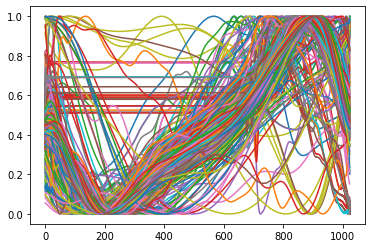

In [7]:
y = target['fy'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

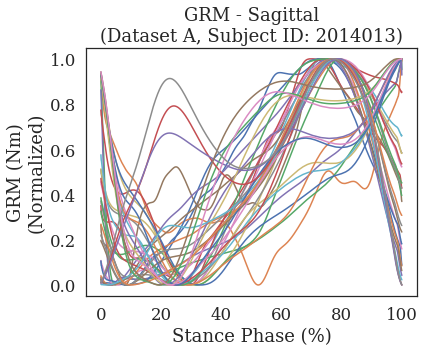

In [9]:
plt.figure(figsize=(6, 5))
mx = target['mx'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(mx.shape[0]):
    plt.plot(x, mx[i, :])

plt.title("GRM - Sagittal\n(Dataset A, Subject ID: 2014013)")
plt.xlabel("Stance Phase (%)")
plt.ylabel("GRM (Nm)\n(Normalized)")
plt.tight_layout()
plt.savefig("../../Figures/dbase1_mx_subject_2014013.svg")

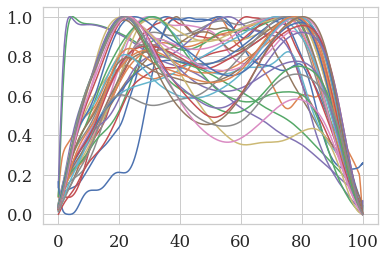

In [39]:
my = target['my'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(my.shape[0]):
    plt.plot(x, my[i, :])

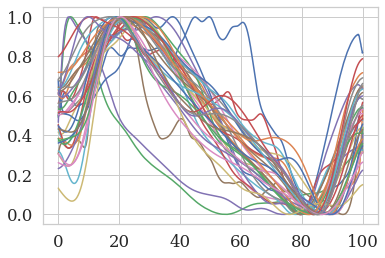

In [40]:
mz = target['mz'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(mz.shape[0]):
    plt.plot(x, mz[i, :])

In [ ]:
features_new = features.drop(columns=['fcc_x', 'fcc_y', 'fcc_z'])
features_new = features_new[[
    'fal_x', 'tam_x', 'fm5_x', 'fm1_x', 'fm2_x',
    'fal_y', 'tam_y', 'fm5_y', 'fm1_y', 'fm2_y',
    'fal_z', 'tam_z', 'fm5_z', 'fm1_z', 'fm2_z',
    'filename'
]]
features_new

In [ ]:
path = '../../Dataset/Processed/data1_f18_t6_n1_all_vel_p2.joblib'
data = {
    'X': features_new,
    'y': target
}
dump(data, path)

# Generating Train Test Sets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load, dump
from sklearn.model_selection import train_test_split

N_SAMPLES = 1024
N_CHANNELS = 15

# path = '../../Dataset/Processed/data2_f72_t3_n1_high_vel.joblib'
# data = load(path)
# features = data['X']
# target = data['y']

path1 = '../../Dataset/Processed/data1_f18_t6_n1_all_vel_p1.joblib'
path2 = '../../Dataset/Processed/data1_f18_t6_n1_all_vel_p2.joblib'

data1 = load(path1)
data2 = load(path2)

features1 = data1['X']
features2 = data2['X']

target1 = data1['y']
target2 = data2['y']

print(features1.shape)
print(features2.shape)

print(target1.shape)
print(target2.shape)

In [ ]:
features = pd.concat([features1, features2])
target = pd.concat([target1, target2])

# print(features.shape)
# print(target.shape)

features

In [ ]:
# features_new = features.drop(columns=['fcc_x', 'fcc_y', 'fcc_z'])
# features_new = features_new[[
#     'fal_x', 'tam_x', 'fm5_x', 'fm1_x', 'fm2_x',
#     'fal_y', 'tam_y', 'fm5_y', 'fm1_y', 'fm2_y',
#     'fal_z', 'tam_z', 'fm5_z', 'fm1_z', 'fm2_z'
# ]]
# features_new

In [ ]:
x = features_new['fal_y'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

In [ ]:
# traget = target[['fx', 'fy', 'fz']]
traget

In [ ]:
X = features_new.to_numpy().reshape(-1, N_SAMPLES, N_CHANNELS)
y = target.to_numpy().reshape(-1, N_SAMPLES, 6)

print(X.shape)
print(y.shape)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

In [ ]:
path = '../../Dataset/Processed/data1_f18_t6_n1_all_vel_combined.joblib'
# data = {
#     'train_X': train_X,
#     'test_X': test_X,
#     'train_y': train_y,
#     'test_y': test_y
# }
data = {
    'X': features,
    'y': target
}
dump(data, path)

In [ ]:
for i in range(train_X.shape[2]):
    plt.plot(train_X[i, :, 2])

# Visualization

In [ ]:
import joblib
path = "../../Dataset/Processed/data1_f15_t6_n1_all_vel_p1.joblib"
data = joblib.load(path)

In [ ]:
x = data["y"]
x.shape

In [ ]:
data.keys()